D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

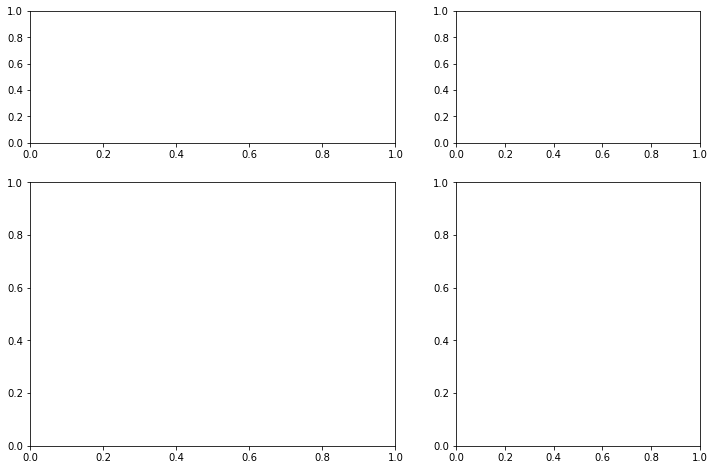

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from matplotlib.patches import Ellipse  
from sklearn.datasets import load_iris  
from sklearn.decomposition import PCA  
from sklearn.neighbors import KernelDensity  
from scipy import stats  
# 1. 加载 Iris 数据集  
iris = load_iris()  
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)  
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)  
# print(df.head())

# 2. PCA 降维  
pca = PCA(n_components=2)  
principal_components = pca.fit_transform(df.iloc[:, :-1])  
dat_pca = pd.DataFrame(data=principal_components, columns=['Dim.1', 'Dim.2'])  
dat_pca['sample2'] = df['species']  
# print(dat_pca.head())

# 3. 创建绘图 
gridspec_kw = {'height_ratios': [1, 2],'width_ratios':[3,2]}
fig, axs = plt.subplots(2, 2,figsize=(12,8), gridspec_kw=gridspec_kw)
palette = {"setosa": "#FFA07A", "versicolor": "#FFB6C1", "virginica": "#41b6c4"}   

# 4. 绘制概率密度函数图  
axs[0, 0].clear()
sns.kdeplot(data=dat_pca, x='Dim.1', hue='sample2', fill=True, alpha=0.6,   
            palette=palette, linewidth=0, ax=axs[0, 0],common_norm=True)
axs[0,0].set_xlabel("")  
axs[0,0].set_title("Probability Density Function of PCA Dim.1", fontsize=10)  
axs[0,0].set_xlim(dat_pca['Dim.1'].min(), dat_pca['Dim.1'].max())  
axs[0,0].set_ylim(0, 0.7)  
axs[0,0].axhline(0, color='black', lw=0.5) 

#5.绘制等高线
y = iris.target   
X_pca = principal_components
kde_models = []  
for i in range(len(np.unique(y))):  
    kde = KernelDensity(bandwidth=0.5).fit(X_pca[y == i])  
    kde_models.append(kde)  
 
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1  
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1  
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),  
                     np.arange(y_min, y_max, 0.1))  
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T  
   
for i, (label,color) in enumerate(palette.items()): 
    kde = kde_models[i] 
    log_density = kde.score_samples(grid_points)  
    density = np.exp(log_density).reshape(xx.shape)   
    contour = axs[0,1].contour(xx, yy, density, levels=[0.01, 0.05, 0.1],  
                          colors=color, alpha=0.5)  
    axs[0,1].clabel(contour, inline=True, fontsize=8, fmt='%.2f', colors=color)  
  
axs[0,1].axhline(0, color='grey', lw=0.8, ls='--')  
axs[0,1].axvline(0, color='grey', lw=0.8, ls='--')  
axs[0,1].set_xlabel('PC1', fontsize=8)  
axs[0,1].set_ylabel('PC2', fontsize=8)  
axs[0,1].set_title('Iris Dataset PCA Contour Plot', fontsize=10)  
axs[0,1].grid(True)  
plt.show()

#6.绘制散点图
sns.scatterplot(data=dat_pca, x='Dim.1', y='Dim.2', hue='sample2', palette=palette,   
                style="sample2", s=100, edgecolor="#000000",ax=axs[1,0])  
axs[1,0].axvline(x=0, color="#708090", linestyle='dashed')  
axs[1,0].axhline(y=0, color="#708090", linestyle='dashed')  
  
def draw_ellipse(ax, mean, cov, color):  
    eigenvalues, eigenvectors = np.linalg.eig(cov)  
    width, height = 4* np.sqrt(eigenvalues)  # 椭圆的宽高  
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))  # 椭圆的角度  
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=0.2)  
    axs[1,0].add_patch(ellipse)  

for species in dat_pca['sample2'].unique():  
    subset = dat_pca[dat_pca['sample2'] == species]  
    mean = subset[['Dim.1', 'Dim.2']].mean().values  
    cov = np.cov(subset[['Dim.1', 'Dim.2']], rowvar=False)  # 计算协方差  
    draw_ellipse(plt.gca(), mean, cov, color=palette[species])  # 只传递 color  

axs[1,0].set_title("PCA of Iris Dataset", fontsize=10, color="#000000")  
axs[1,0].set_xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0] * 100, 1)}%)", fontsize=8)  
axs[1,0].set_ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1] * 100, 1)}%)", fontsize=8)  

axs[1,0].legend(fontsize=8,loc='lower right')  
axs[1,0].grid(True)  

#6.绘制箱线图 
boxplot = sns.boxplot(x='sample2', y='Dim.1', data=dat_pca, hue='sample2',  
                      palette=palette,ax=axs[1,1])  
sns.stripplot(x='sample2', y='Dim.1', data=dat_pca,   
              hue='sample2',  palette=palette,  marker='o', alpha=0.6, size=5)  
 
def add_stat_annotation(ax, comparisons):   
    categories = dat_pca['sample2'].cat.categories.tolist()   
    for cat1, cat2 in comparisons:  
        x1 = categories.index(cat1)  
        x2 = categories.index(cat2)   
        y = dat_pca['Dim.1'].max() + 0.2      
        group1 = dat_pca[dat_pca['sample2'] == cat1]['Dim.1']  
        group2 = dat_pca[dat_pca['sample2'] == cat2]['Dim.1']  
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)  
        axs[1,1].text((x1 + x2) / 2, y, f"p = {p_val:.3f}", ha='center',fontsize=8)  

my_comparisons = [('setosa', 'versicolor'), ('versicolor', 'virginica'), ('setosa', 'virginica')]  
add_stat_annotation(boxplot, my_comparisons)  

axs[1,1].set_title("Boxplot of PCA Dim.1 by Species", fontsize=10)  
axs[1,1].set_xlabel("")  
axs[1,1].set_ylabel("")  
axs[1,1].set_ylim(-3.5, 4.5)  
plt.tight_layout()    
plt.show()  